In [2]:
#Scrappe all companies
#!parallel -j10 --progress  wget -P companies https://www.ycombinator.com/companies/{} ::: `seq 10000`

In [1]:
#make gender dictionary (from https://data.world/howarder/gender-by-name# )
#!wget https://query.data.world/s/elahhcphnphgcjetadzjj4flvvcyjd

import pandas as pd
names=pd.read_csv('name_gender.csv')

import csv
names={}
with open('name_gender.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        names[row['name'].lower()]=[row['gender'],row['probability']]
print("%i names with genders loaded."%len(names))

95026 names with genders loaded.


In [2]:
def get_gender(name):
    name=name.split()[0].lower()
    if name in names.keys():
        return names[name][0]
    else:
        return None
get_gender('Emma Sanchez')

'F'

In [3]:
from bs4 import BeautifulSoup
company_html = "companies/*"

def get_founders(company_html):
    content =open(company_html, "r",encoding="utf-8").read()
    soup = BeautifulSoup(content)
    title=soup.title.text.split('|')[0].rstrip()

    founders_div = soup.find_all("div", class_="founder-card")
    founders=[]
    genders=[]
    
    batch = soup.find("i", class_="fa-y-combinator").parent.text
    batch = int(batch[1:]) if 'S' in batch else 0.5+int(batch[1:]) #convert to float
    for founder_div in founders_div:
        founders.append(founder_div.find("div", class_="heavy").text)
        genders.append(get_gender(founders[-1]))
    if len(founders)==0:
        founders.append(None)
        genders.append(None)
        #print("%s has no founders."%title)
    return title,founders,genders,batch

company_html = "companies/12"
get_founders(company_html)

('Hipmob', ['Olufemi Omojola'], ['M'], 12.5)

In [4]:
import concurrent.futures
import glob
from tqdm import tqdm

companies_html=glob.glob('companies/*')
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    # map
    l = list(tqdm(
        executor.map(
            lambda company_html: get_founders(company_html), companies_html
        ), total=len(companies_html)))

print('Done.')

100%|██████████| 1681/1681 [00:58<00:00, 28.84it/s]

Done.


In [5]:
df = pd.DataFrame(l) 
df.columns = ['Company', 'Names', 'Genders', 'Batch']
df

,Company,Names,Genders,Batch
0,The Muse,"[Alex Cavoulacos, Kathryn Minshew]","[M, F]",12.5
1,MarketBrief,[Chris Auer],[M],11.0
2,Loop Genomics,[Tuval Ben-Yehezkel],[None],16.5
3,Toymail,[Gauri Nanda],[F],16.5
4,UpLabs,[Matt Dellac],[M],16.5
...,...,...,...,...
1676,Petcube,"[Andrey Klen, Alex Neskin, Yaroslav Azhnyuk]","[M, M, M]",16.5
1677,Daily,[Kwindla Hultman Kramer],[None],16.5
1678,Mio,"[James Cundle, Tom Hadfield]","[M, M]",16.5
1679,Algoriz,[Soraya Taghavi],[F],16.5


In [6]:
df['F_ratio'] = df.apply(lambda x: x['Genders'].count('F')/(len(x['Genders'])) ,axis=1)
df['N_Female'] = df.apply(lambda x: x['Genders'].count('F') ,axis=1)
df['N_Founders'] = df.apply(lambda x: 0 if x['Names']==[None] else len(x['Names']) ,axis=1)
df

,Company,Names,Genders,Batch,F_ratio,N_Female,N_Founders
0,The Muse,"[Alex Cavoulacos, Kathryn Minshew]","[M, F]",12.5,0.5,1,2
1,MarketBrief,[Chris Auer],[M],11.0,0.0,0,1
2,Loop Genomics,[Tuval Ben-Yehezkel],[None],16.5,0.0,0,1
3,Toymail,[Gauri Nanda],[F],16.5,1.0,1,1
4,UpLabs,[Matt Dellac],[M],16.5,0.0,0,1
...,...,...,...,...,...,...,...
1676,Petcube,"[Andrey Klen, Alex Neskin, Yaroslav Azhnyuk]","[M, M, M]",16.5,0.0,0,3
1677,Daily,[Kwindla Hultman Kramer],[None],16.5,0.0,0,1
1678,Mio,"[James Cundle, Tom Hadfield]","[M, M]",16.5,0.0,0,2
1679,Algoriz,[Soraya Taghavi],[F],16.5,1.0,1,1


In [7]:
df.iloc[11]

Company               Copia
Names         [Komal Ahmad]
Genders                 [F]
Batch                  16.5
F_ratio                   1
N_Female                  1
N_Founders                1
Name: 11, dtype: object

In [8]:
df[df['N_Founders']>0].mean()

Batch         15.244853
F_ratio        0.127230
N_Female       0.223529
N_Founders     1.824265
dtype: float64

In [9]:
import numpy as np
df_batches = df.groupby("Batch").agg([np.mean, np.std, len])
df_batches.head()

F_ratio                  N_Female               N_Founders            \
           mean       std   len      mean       std len       mean       std   
Batch                                                                          
5.0    0.000000  0.000000  10.0  0.000000  0.000000  10   0.600000  0.699206   
6.0    0.113636  0.303390  11.0  0.181818  0.404520  11   1.090909  1.136182   
6.5    0.000000  0.000000   7.0  0.000000  0.000000   7   0.857143  0.690066   
7.0    0.026316  0.114708  19.0  0.052632  0.229416  19   1.315789  0.885226   
7.5    0.038462  0.138675  13.0  0.076923  0.277350  13   0.769231  1.363442   

           
      len  
Batch      
5.0    10  
6.0    11  
6.5     7  
7.0    19  
7.5    13

* basically like 10% of all people are always women and it's stayed that way? What’s the %?


<AxesSubplot:title={'center':'Total companies funded'}, xlabel='Batch'>

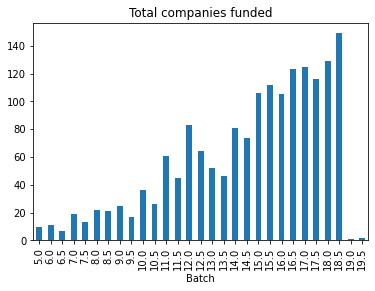

In [10]:
df.groupby('Batch')['N_Founders'].count().plot(title='Total companies funded',kind='bar')

<AxesSubplot:title={'center':'% of female founders vs all founders'}, xlabel='Batch'>

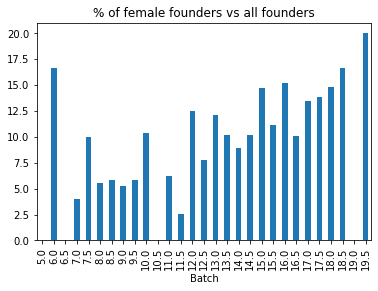

In [11]:
f=df.groupby('Batch')['N_Female'].sum()
t=df.groupby('Batch')['N_Founders'].sum()
r=f/t*100
r.plot(title='% of female founders vs all founders',kind='bar')

<AxesSubplot:title={'center':'% of solo female founders vs all solo founders'}, xlabel='Batch'>

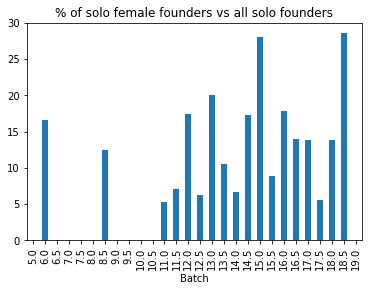

In [12]:
f=df[(df['N_Female']==1)&(df['N_Founders']==1)].groupby('Batch')['N_Female'].sum()
t=df[(df['N_Founders']==1)].groupby('Batch')['N_Founders'].sum()
r=f/t*100
r.plot(title='% of solo female founders vs all solo founders',kind='bar')

<AxesSubplot:title={'center':'% of solo female founders vs all solo founders'}, xlabel='Batch'>

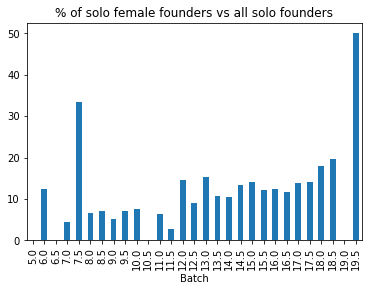

In [13]:
f=df[(df['N_Founders']<=2)].groupby('Batch')['N_Female'].sum()
t=df[(df['N_Founders']<=2)].groupby('Batch')['N_Founders'].sum()
r=f/t*100
r.plot(title='% of solo female founders vs all solo founders',kind='bar')

 * ideally we want a % year over year of female-only vs female/male cofounded. as a % of ALL. so 3% this year were all women, 6% were mixed teams, 91% were all men, for example

,All Female,Mixed,All Male
Batch,,,
5.0,NaN,NaN,10
6.0,1.0,1.0,9
6.5,NaN,NaN,7
7.0,NaN,NaN,18
7.5,NaN,NaN,12
8.0,NaN,NaN,21
8.5,1.0,0.0,20
9.0,NaN,NaN,24
9.5,NaN,NaN,16


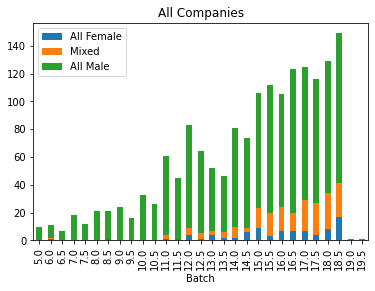

In [22]:
t=pd.DataFrame()
t['Mixed']=df.groupby('Batch')['N_Founders'].size()
t['All Female']=df[(df['F_ratio']==1)].groupby('Batch')['N_Founders'].size()
t['All Male']=  df[(df['F_ratio']==0)].groupby('Batch')['N_Founders'].size()
t['Mixed']=                         df.groupby('Batch')['N_Founders'].size()-t['All Female']-t['All Male']
t[['All Female','Mixed','All Male']].plot(kind='bar', stacked=True,title="All Companies");
t[['All Female','Mixed','All Male']]

,All Female,Mixed,All Male
Batch,,,
5.0,NaN,NaN,4.0
6.0,1.0,0.0,5.0
6.5,NaN,NaN,4.0
7.0,NaN,NaN,6.0
7.5,NaN,NaN,1.0
8.0,NaN,NaN,5.0
8.5,1.0,0.0,7.0
9.0,NaN,NaN,5.0
9.5,NaN,NaN,6.0


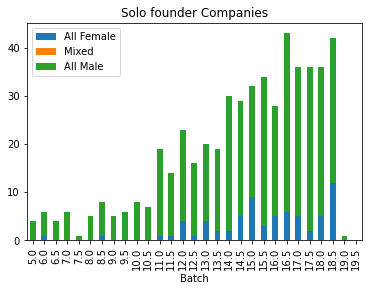

In [24]:
t=pd.DataFrame()
size=1
t['Mixed']=df.groupby('Batch')['N_Founders'].size()
t['All Female']=df[(df['N_Founders']==size)&(df['F_ratio']==1)].groupby('Batch')['N_Founders'].count()
t['All Male']=  df[(df['N_Founders']==size)&(df['F_ratio']==0)].groupby('Batch')['N_Founders'].count()
t['Mixed']=     df[(df['N_Founders']==size)                   ].groupby('Batch')['N_Founders'].count()-t['All Female']-t['All Male']
t[['All Female','Mixed','All Male']].plot(kind='bar', stacked=True,title="Solo founder Companies");
t[['All Female','Mixed','All Male']]

,All Female,Mixed,All Male
Batch,,,
5.0,NaN,NaN,1.0
6.0,NaN,NaN,1.0
6.5,NaN,NaN,1.0
7.0,NaN,NaN,7.0
7.5,NaN,NaN,NaN
8.0,NaN,NaN,4.0
8.5,NaN,NaN,3.0
9.0,NaN,NaN,6.0
9.5,NaN,NaN,3.0


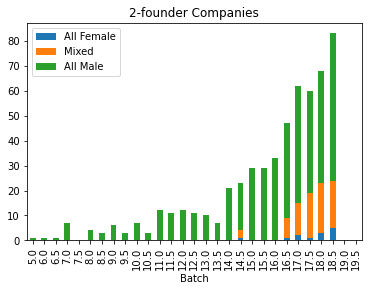

In [25]:
t=pd.DataFrame()
size=2
t['Mixed']=df.groupby('Batch')['N_Founders'].size()
t['All Female']=df[(df['N_Founders']==size)&(df['F_ratio']==1)].groupby('Batch')['N_Founders'].count()
t['All Male']=  df[(df['N_Founders']==size)&(df['F_ratio']==0)].groupby('Batch')['N_Founders'].count()
t['Mixed']=     df[(df['N_Founders']==size)                   ].groupby('Batch')['N_Founders'].count()-t['All Female']-t['All Male']
t[['All Female','Mixed','All Male']].plot(kind='bar', stacked=True,title="2-founder Companies");
t[['All Female','Mixed','All Male']]

,All Female,Mixed,All Male
Batch,,,
6.0,NaN,1.0,NaN
7.0,NaN,NaN,1.0
7.5,NaN,NaN,2.0
8.0,NaN,NaN,1.0
8.5,NaN,NaN,1.0
9.5,NaN,NaN,1.0
10.0,NaN,1.0,NaN
10.5,NaN,NaN,1.0
11.0,NaN,1.0,4.0


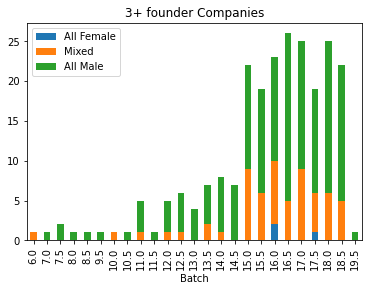

In [26]:
t=pd.DataFrame()
size=2
t['All']=df[df['N_Founders']>size].groupby('Batch')['N_Founders'].size()
t['All Female']=df[(df['N_Founders']>size)&(df['F_ratio']==1)].groupby('Batch')['N_Founders'].size()
t['All Male']=  df[(df['N_Founders']>size)&(df['F_ratio']==0)].groupby('Batch')['N_Founders'].size()
t['Mixed']=    (df[(df['N_Founders']>size)&(df['F_ratio']>0)&(df['F_ratio']<1)].groupby('Batch')['N_Founders'].size())
t[['All Female','Mixed','All Male']].plot(kind='bar', stacked=True, title="3+ founder Companies");
t[['All Female','Mixed','All Male']]

,All Female,Mixed,All Male
Batch,,,
5.0,NaN,NaN,100.000000
6.0,9.090909,9.090909,81.818182
6.5,NaN,NaN,100.000000
7.0,NaN,5.263158,94.736842
7.5,NaN,7.692308,92.307692
8.0,NaN,4.545455,95.454545
8.5,4.761905,NaN,95.238095
9.0,NaN,4.000000,96.000000
9.5,NaN,5.882353,94.117647


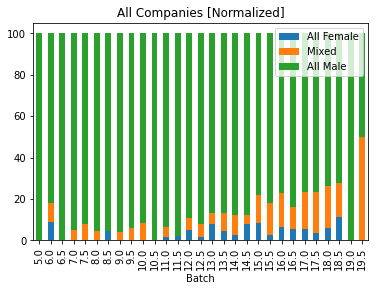

In [27]:
t=pd.DataFrame()
t['All']=df.groupby('Batch')['N_Founders'].size()
t['All Female']=df[(df['F_ratio']==1)].groupby('Batch')['N_Founders'].size()/t['All']*100
t['All Male']=  df[(df['F_ratio']==0)].groupby('Batch')['N_Founders'].size()/t['All']*100
t['Mixed']=    (df[(df['F_ratio']>0)&(df['F_ratio']<1)].groupby('Batch')['N_Founders'].size())/t['All']*100
t[['All Female','Mixed','All Male']].plot(kind='bar', stacked=True, title="All Companies [Normalized]");
t[['All Female','Mixed','All Male']]

,All Female,Mixed,All Male
Batch,,,
5.0,NaN,NaN,100.000000
6.0,16.666667,NaN,83.333333
6.5,NaN,NaN,100.000000
7.0,NaN,NaN,100.000000
7.5,NaN,NaN,100.000000
8.0,NaN,NaN,100.000000
8.5,12.500000,NaN,87.500000
9.0,NaN,NaN,100.000000
9.5,NaN,NaN,100.000000


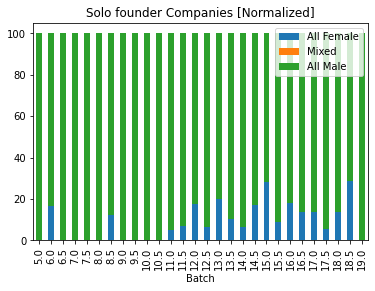

In [28]:
t=pd.DataFrame()
size=1
t['All']=df[(df['N_Founders']==size)].groupby('Batch')['N_Founders'].size()
t['All Female']=df[(df['N_Founders']==size)&(df['F_ratio']==1)].groupby('Batch')['N_Founders'].size()/t['All']*100
t['All Male']=  df[(df['N_Founders']==size)&(df['F_ratio']==0)].groupby('Batch')['N_Founders'].size()/t['All']*100
t['Mixed']=    (df[(df['N_Founders']==size)&(df['F_ratio']>0)&(df['F_ratio']<1)].groupby('Batch')['N_Founders'].size())/t['All']*100
t[['All Female','Mixed','All Male']].plot(kind='bar', stacked=True, title="Solo founder Companies [Normalized]");
t[['All Female','Mixed','All Male']]

,All Female,Mixed,All Male
Batch,,,
5.0,NaN,NaN,100.000000
6.0,NaN,NaN,100.000000
6.5,NaN,NaN,100.000000
7.0,NaN,12.500000,87.500000
7.5,NaN,100.000000,NaN
8.0,NaN,20.000000,80.000000
8.5,NaN,NaN,100.000000
9.0,NaN,14.285714,85.714286
9.5,NaN,25.000000,75.000000


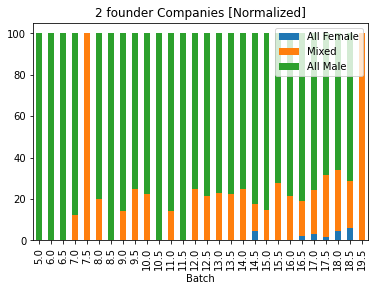

In [29]:
t=pd.DataFrame()
size=2
t['All']=df[(df['N_Founders']==size)].groupby('Batch')['N_Founders'].size()
t['All Female']=df[(df['N_Founders']==size)&(df['F_ratio']==1)].groupby('Batch')['N_Founders'].size()/t['All']*100
t['All Male']=  df[(df['N_Founders']==size)&(df['F_ratio']==0)].groupby('Batch')['N_Founders'].size()/t['All']*100
t['Mixed']=    (df[(df['N_Founders']==size)&(df['F_ratio']>0)&(df['F_ratio']<1)].groupby('Batch')['N_Founders'].size())/t['All']*100
t[['All Female','Mixed','All Male']].plot(kind='bar', stacked=True, title="2 founder Companies [Normalized]");
t[['All Female','Mixed','All Male']]

,All Female,Mixed,All Male
Batch,,,
6.0,NaN,100.000000,NaN
7.0,NaN,NaN,100.000000
7.5,NaN,NaN,100.000000
8.0,NaN,NaN,100.000000
8.5,NaN,NaN,100.000000
9.5,NaN,NaN,100.000000
10.0,NaN,100.000000,NaN
10.5,NaN,NaN,100.000000
11.0,NaN,20.000000,80.000000


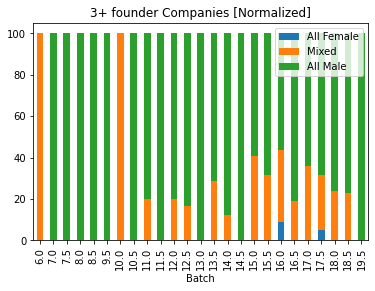

In [30]:
t=pd.DataFrame()
size=2
t['All']=df[df['N_Founders']>size].groupby('Batch')['N_Founders'].size()
t['All Female']=df[(df['N_Founders']>size)&(df['F_ratio']==1)].groupby('Batch')['N_Founders'].size()/t['All']*100
t['All Male']=  df[(df['N_Founders']>size)&(df['F_ratio']==0)].groupby('Batch')['N_Founders'].size()/t['All']*100
t['Mixed']=    (df[(df['N_Founders']>size)&(df['F_ratio']>0)&(df['F_ratio']<1)].groupby('Batch')['N_Founders'].size())/t['All']*100
t[['All Female','Mixed','All Male']].plot(kind='bar', stacked=True, title="3+ founder Companies [Normalized]");
t[['All Female','Mixed','All Male']]

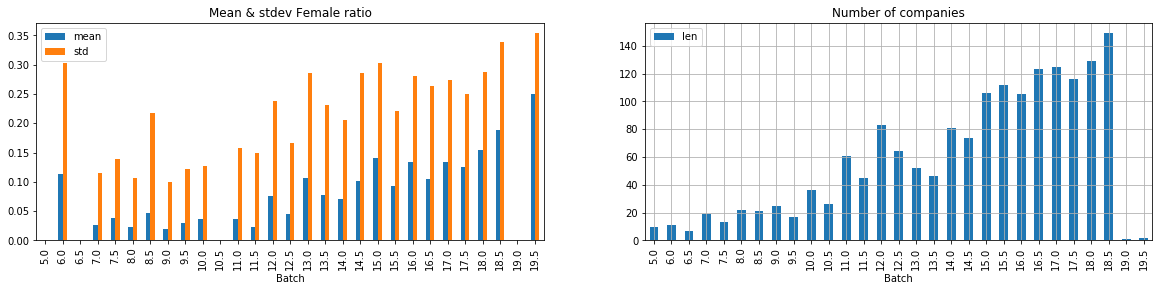

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20, 4))
df.groupby("Batch").agg([np.mean,np.std])['F_ratio'].plot(kind = "bar", y = ["mean","std"], 
            title = "Mean & stdev Female ratio", ax=ax[0])
df.groupby("Batch").agg([len])['F_ratio'].plot(kind = "bar", y = ["len"], 
            title = "Number of companies", grid=True, ax=ax[1])

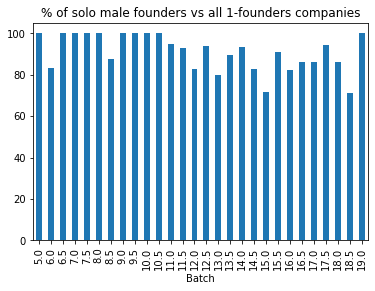

In [17]:
f=df[(df['N_Founders']==1)&(df['F_ratio']==0)].groupby('Batch')['F_ratio'].count()
t=df[(df['N_Founders']==1)].groupby('Batch')['F_ratio'].count()
r=f/t*100
r.plot(title='% of solo male founders vs all 1-founders companies',kind='bar')

In [18]:
df[(df['N_Founders']==1)&(df['F_ratio']==0)]['N_Founders'].sum()/\
df[(df['N_Founders']==1)]['N_Founders'].sum()

0.8667953667953668

In [19]:
df[(df['F_ratio']==1) & (df['N_Founders']==1)]

,Company,Names,Genders,Batch,F_ratio,N_Founders
3,Toymail,[Gauri Nanda],[F],16.5,1.0,1
11,Copia,[Komal Ahmad],[F],16.5,1.0,1
38,Netomi,[Puneet Mehta],[F],16.5,1.0,1
44,Embark,[Taylor Malloy],[F],11.0,1.0,1
71,Georgette Packaging,[Sarah Landstreet],[F],16.5,1.0,1
...,...,...,...,...,...,...
1596,zPREDICTA,[Julia Kirshner],[F],15.0,1.0,1
1627,HER,[Robyn Exton],[F],15.0,1.0,1
1639,StyleBee,[Anna Santeramo],[F],15.0,1.0,1
1647,Vive,[Alanna Gregory],[F],15.0,1.0,1


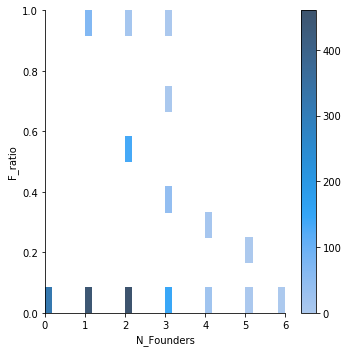

In [20]:
import seaborn as sns
sns.displot(df,x='N_Founders',y='F_ratio', cbar=True,palette='Dark2')

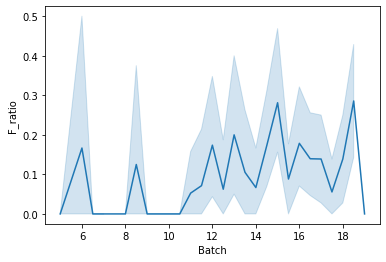

In [21]:
from numpy import median
sns.lineplot(
        data=df[df['N_Founders']==1], x="Batch", y="F_ratio")

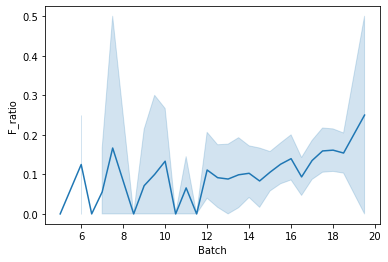

In [22]:
sns.lineplot(
        data=df[df['N_Founders']>1], x="Batch", y="F_ratio")

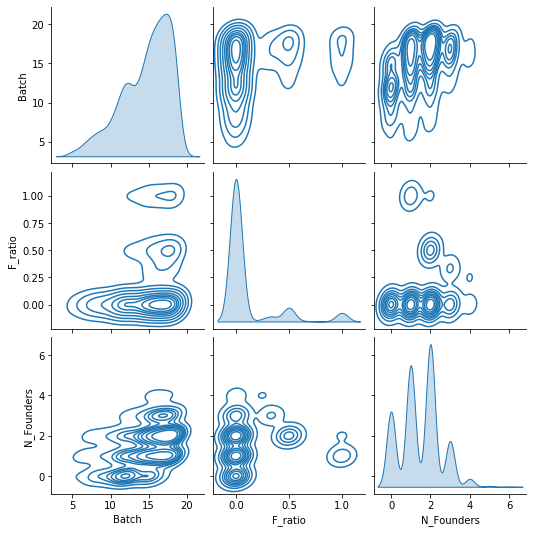

In [23]:
sns.pairplot(df,kind='kde')

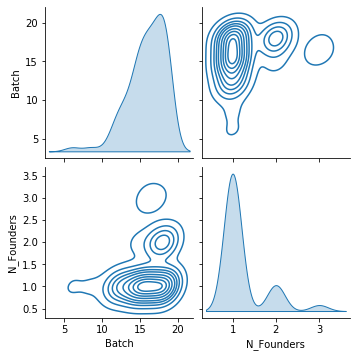

In [24]:
sns.pairplot(df[df['F_ratio']==1][['Batch','N_Founders']],kind='kde')

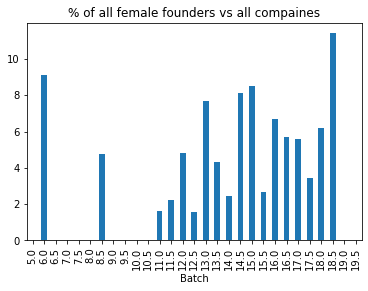

In [25]:
f=df[df['F_ratio']==1].groupby('Batch')['F_ratio'].count()
t=df.groupby('Batch')['F_ratio'].count()
r=f/t*100
r.plot(title='% of all female founders vs all compaines',kind='bar')

In [26]:
len(df[df['F_ratio']==1]),len(df[(df['F_ratio']==1)&(df['N_Founders']>1)])

(85, 16)

In [27]:
df.apply(lambda x: x['Genders'].count('M') ,axis=1).sum(),\
df.apply(lambda x: x['Genders'].count('F') ,axis=1).sum(),\


(1938, 304)